In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network
from DAG import DAG
from gradient_descent import gradient_descent
from tqdm.notebook import tqdm
from genetic_algorithm import run_genetic_algorithm
from LoCo_algorithm import run_loco

In [32]:
nd = run_loco(dag, VERBOSE = 0, TOP_N_TO_MAX=3)

TOP_N_TO_MAX 3


In [39]:
nd.get_varsortability(smart = 1, N = 1000000)

{'smart': 0.7719298245614035}

In [43]:
from tqdm.notebook import tqdm

In [133]:
suite = []

con = 0.7
sizes = [13, 11, 9, 7, 5]
for size in sizes:
    dag = DAG(n = size, connectivity = con)

    suite.append(dag)

In [137]:
locos = []
genetic = []
genetic_flip = []


from time import time


times = []

for size, dag in tqdm(zip(sizes,suite), total = len(sizes)):
    print("size", size)

    print("running loco")
    for k in ([6,5,4,3]):
        t = time()
        nd = run_loco(dag, VERBOSE = 0, TOP_N_TO_MAX=k)
        T = time()-t
        var = nd.get_varsortability(smart = 1, N = 1000000)["smart"]
        if var < 1:
            break
    locos.append(var)
    times.append(T)

    print("running genetic")
    t = time()
    nd = run_genetic_algorithm(dag, population = 10, generations = 10)
    times.append(time()-t)
    var = nd[0].get_varsortability(smart = 1, N = 1000000)["smart"]
    genetic.append(var)

    print("running genetic_flip")
    t = time()
    nd = run_genetic_algorithm(dag, population = 10, generations = 10, flip_only = 1)
    times.append(time()-t)
    var = nd[0].get_varsortability(smart = 1, N = 1000000)["smart"]
    genetic_flip.append(var)

np.savetxt("locos_07.csv", np.array(locos), delimiter=",")
np.savetxt("genetic_07.csv", np.array(genetic), delimiter=",")
np.savetxt("genetic_flip_07.csv", np.array(genetic_flip), delimiter=",")
np.savetxt("times_07.csv", np.array(times), delimiter=",")


  0%|          | 0/5 [00:00<?, ?it/s]

size 13
running loco
TOP_N_TO_MAX 6
running genetic
running genetic_flip
size 11
running loco
TOP_N_TO_MAX 6
running genetic
running genetic_flip
size 9
running loco
TOP_N_TO_MAX 6
running genetic
running genetic_flip
size 7
running loco
TOP_N_TO_MAX 6
running genetic
running genetic_flip
size 5
running loco
TOP_N_TO_MAX 6
TOP_N_TO_MAX 5
TOP_N_TO_MAX 4
TOP_N_TO_MAX 3
running genetic
running genetic_flip


In [138]:
print(locos)


[0.81, 0.8633093525179856, 0.8055555555555556, 0.9736842105263158, 1.0]


In [139]:
print(locos)
print(genetic)
print(genetic_flip)
print(times)

[0.81, 0.8633093525179856, 0.8055555555555556, 0.9736842105263158, 1.0]
[0.87, 0.7889908256880734, 0.8095238095238095, 0.7105263157894737, 0.7777777777777778]
[0.9481481481481482, 0.9210526315789473, 0.9, 0.9473684210526315, 1.0]
[91.14781308174133, 80.25656294822693, 80.48229026794434, 61.59268856048584, 69.63779544830322, 69.71787405014038, 10.662694931030273, 59.09227657318115, 58.96857810020447, 3.7651703357696533, 48.24166965484619, 48.398120403289795, 0.36758875846862793, 37.68380165100098, 37.496779441833496]


In [70]:
locotime = times[::3]
gentime = times[1::3]
fliptime = times[2::3]

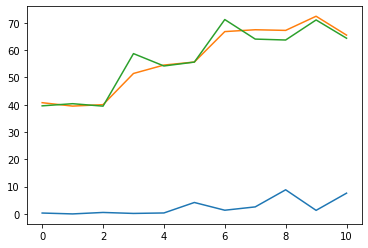

In [74]:
plt.plot(locotime[:-1])
plt.plot(gentime[:-1])
plt.plot(fliptime[:-1])

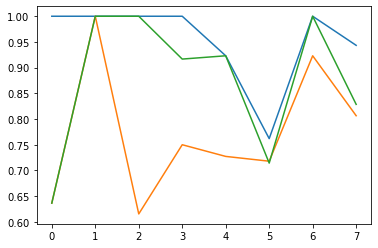

In [92]:
plt.plot(locos)
plt.plot(genetic)
plt.plot(genetic_flip)

# Sweep connectivity

In [8]:
size = 5

num_iterations = 2

sweep = np.linspace(0.1, 1, 2)


results = np.zeros((len(sweep), num_iterations))
actual_connections = np.zeros((len(sweep), num_iterations))

lrs = [0.1, 0.01, 0.01, 0.001, 0.0001]
for i, connectivity in tqdm(enumerate(sweep), total = len(sweep)):
    for j in tqdm(range(num_iterations)):
        for l in range(5):
            dag = DAG(n = size, strength=2, connectivity = connectivity)
            actual_connections[i,j] = (dag.adjacency_matrix != 0).sum()
            print("Starting gradient descent")
            best = gradient_descent(dag, num_iterations = 50*(), lr = lrs[l], VERBOSE = False)
            print("Finished gradient descent")
            dag.adjacency_matrix = best
            vs = dag.get_varsortability(smart = True, N = 10000000)
            if vs["smart"] < 1:
                break
            else: 
                print("Failed to converge, trying again")
        results[i,j] = vs["smart"]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Starting gradient descent


KeyboardInterrupt: 

In [12]:
np.linspace(0.1, 1, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [4]:
# save as csv files
np.savetxt("results_10.csv", results, delimiter=",")
np.savetxt("actual_connections_10.csv", actual_connections, delimiter=",")

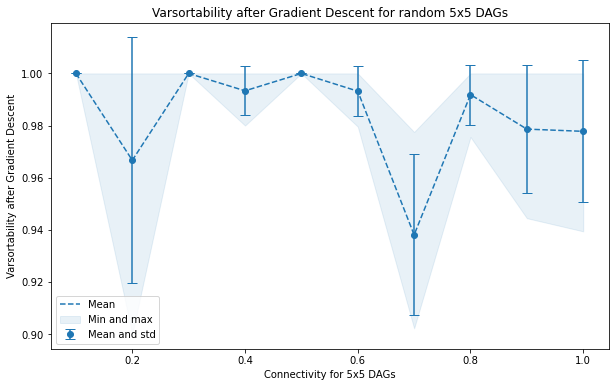

In [5]:
# make the plot

color = "#1f77b4"

mean, std = np.mean(results, axis = 1), np.std(results, axis = 1)

_max, _min = np.max(results, axis = 1), np.min(results, axis = 1)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(sweep, np.mean(results, axis = 1), '--', label = "Mean", color = color)
# make error bars
ax.fill_between(sweep, _min, _max, alpha = 0.1, label = "Min and max", color = color)
ax.errorbar(sweep, mean, yerr = std, fmt = 'o', label = "Mean and std", capsize = 5, color = color)

ax.set_xlabel("Connectivity for 5x5 DAGs")
ax.set_ylabel("Varsortability after Gradient Descent")
ax.legend()

plt.title("Varsortability after Gradient Descent for random 5x5 DAGs")
plt.show()

In [8]:
size = 5
dag = DAG(n = size, strength=2, connectivity = 0.4)
print("Starting gradient descent")
best = gradient_descent(dag, num_iterations = 50, lr = 0.001, VERBOSE = True)
dag.adjacency_matrix = best
dag.get_varsortability(smart = True, N = 10000000)

Starting gradient descent
Iteration 0: loss = 9.467
current_guess: [-0.88717038  2.          1.41794801  1.26923252  2.         -0.06696657
  1.04803132]
varsortability: 1.0
Iteration 1: loss = 9.233
Iteration 2: loss = 9.560
Iteration 3: loss = 9.578
Iteration 4: loss = 9.491
Iteration 5: loss = 9.459
Iteration 6: loss = 9.565
Iteration 7: loss = 9.511
Iteration 8: loss = 8.259
Iteration 9: loss = 9.391
Iteration 10: loss = 9.291
Iteration 11: loss = 8.065
Iteration 12: loss = 8.039
Iteration 13: loss = 7.517
Iteration 14: loss = 7.818
Iteration 15: loss = 8.011
Iteration 16: loss = 9.609
Iteration 17: loss = 9.548
Iteration 18: loss = 9.395
Iteration 19: loss = 9.291
Iteration 20: loss = 9.397
Iteration 21: loss = 9.189
Iteration 22: loss = 9.197
Iteration 23: loss = 9.346
Iteration 24: loss = 9.581
Iteration 25: loss = 9.551
Iteration 26: loss = 9.481
Iteration 27: loss = 9.412
Iteration 28: loss = 9.590
Iteration 29: loss = 9.560
Iteration 30: loss = 9.555
Iteration 31: loss = 9.54

{'smart': 0.7272727272727273}

In [9]:
min(4,1)

1